# AB Testing On Conversion Rate
Jinxin Ma 01/05/2018

The structure of this notebook is as follows:
    1. Exploratory Data Analysis
    2. Two-sample Z-test on entire dataset
    3. Conversion rate by variable
    4. Conversion rate by country
    5. Algorithm design 1 - stratification
    6. Algorithm design 2 - logistic regression

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals

# display plots in notebook
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 18,
         'axes.titlesize': 18,
         'xtick.labelsize': 18,
         'ytick.labelsize': 16}
plt.rcParams.update(params)

## 1. Exploratory data analysis

First, let's read the data and take a look at the first few rows of each dataset.

In [45]:
test = pd.read_csv('test_data_table.csv')
user = pd.read_csv('user_data_table.csv')

In [46]:
test.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1


In [47]:
user.head(5)

,user_id,sex,age,country
0,765821,M,20,Democratic Republic of the Congo
1,343561,F,27,Luxembourg
2,118744,M,23,Canada
3,987753,F,27,Switzerland
4,554597,F,20,France


From the result below, we see that there are 453,321 unique users in the test table and 452,867 in the user table.

In [48]:
print (test.shape, user.shape)
print (test.user_id.nunique())
print (user.user_id.nunique())

(453321, 9) (452867, 4)
453321
452867


Let's merge the demographic information for each user by joining two dataframes.

In [49]:
test_user = pd.merge(test, user, on='user_id', how='left')

In [50]:
test_user.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,FR,NaN,IE,1,0,M,32.0,France
1,497851,2015-12-04,Ads,Web,FR,Google,IE,0,1,M,21.0,Democratic Republic of the Congo
2,848402,2015-12-04,Ads,Web,FR,Facebook,Chrome,0,0,M,34.0,France
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Democratic Republic of the Congo
4,548435,2015-11-30,Ads,Web,FR,Google,FireFox,0,1,M,19.0,Democratic Republic of the Congo


Check the number of missing values in each variable. There are missing values in ads_channel, sex, age, and country.

In [51]:
missing_df = pd.DataFrame(test_user.isnull().sum()).reset_index()
missing_df.columns = ['column', 'missing value count']
missing_df

,column,missing value count
0,user_id,0
1,date,0
2,source,0
3,device,0
4,browser_language,0
5,ads_channel,271444
6,browser,0
7,conversion,0
8,test,0
9,sex,454


For categorical variables, let's fill missing values with "NA", for age which is continuous, let's impute missing values with median age.

In [52]:
# test_user['ads_channel'].fillna('NA', inplace=True)
# test_user['sex'].fillna('NA', inplace=True)
# test_user['country'].fillna('NA', inplace=True)
test_user['age'].fillna(test_user['age'].median(), inplace=True)

It makes sense to convert age into age groups so we can check if the conversion rates are different across age groups. Here, I choose to split based on the median age which is 26. Alternatively, we can use quartile or clustering to split age into more groups.

In [53]:
def age_cat(value):
    if value <= 25:
        return '<=25'
    else: return '25+'
    
test_user['age_group'] = test_user['age'].apply(age_cat)

Eventually, let's remove France and samples that have missing country values from the dataset because:
1. Nothing has changed for France
2. Number of missing values is small, so they won't affect statistical tests much

In [54]:
test_user = test_user[(test_user.country != 'France') & (test_user.country != 'missing')]
test_user.shape

(401539, 13)

**Summary: ** Now our dataset is ready to be analyzed, in the next section we will examine whether the localized translations were really doing worse.

## 2. Two Sample Z-test on entire data set

First let's simulate the test done by the team/data scientist, which is to run the test using all data.

When testing whether the conversion rate is statistically different between the experiment and the control groups, we usually apply a two-sample proportion test. Options include Chi-square test, Z-test, etc. When the sample size is large, these tests lead to the same statistical result, i.e. P-value. I chose to use Z-test here because our sample size is sufficiently large.

The team's assumption is:

$H_{0}:\ Conversion\ rate_{experiment\ group} = Conversion\ rate_{control\ group}$

$H_{1}: Conversion\ rate_{experiment\ group} < Conversion\ rate_{control\ group}$


First, let's subset the data into an experiment group and a control group

In [55]:
experiment_group = test_user[(test_user.test == 1)]
control_group = test_user[(test_user.test == 0)]

We can see from below that initial comparison of the conversion rates between the experiment and the control groups indicates that the non-localized translation was doing better.

In [56]:
control_group.conversion.mean()

0.04833042316066309

In [57]:
experiment_group.conversion.mean()

0.043424713982118966

Next, let's apply a one-sided Z-test on two groups. We got a p-value of 5.77 x 10^(-74) which is less than the 5% significance level. We cannot reject the null hypothesis that the conversion rate of the experiment group is greater than or equal to that of the control group.

In [58]:
import statsmodels.api as sm
def two_sample_z_test(df, alternative='two-sided'):
    """
    This function returns the P-value from a two-sample Z-test
    """
    test_df = df[df.test == 1]
    control_df = df[df.test == 0]

    test_convert = test_df.conversion.sum()
    control_convert = control_df.conversion.sum()

    test_n = len(test_df.conversion)
    control_n = len(control_df.conversion)
    z, p_value = sm.stats.proportions_ztest([test_convert, control_convert], 
                                            [test_n, control_n],
                                           alternative=alternative)
    return(z, p_value)

z, pvalue = two_sample_z_test(test_user, alternative='smaller')
print('Z-score is: {}'.format(z))
print('P-value is: {}'.format(pvalue))

Z-score is: -7.42202142201
P-value is: 5.76730754076e-14


**Summary: ** From the test result we see that what the team observed was true, the conversion rate of the test group is indeed less than that of the control group. However, is that the whole story? Let's explore more in the next section.

## 3. Conversion rate by variable

In statistical analysis, there is concept called **confounding variable** which influences the effect of independent variables on the dependent variable. They can cause our statistical inference to be inaccurate. In this section, let's look into several variables and try to identify if they might be the reason for the counter-intuitive result seen by the team.

In [59]:
def conversion_barplot(test_df, control_df, col):
    test = test_df.groupby(col).conversion.mean().reset_index()
    control = control_df.groupby(col).conversion.mean().reset_index()
    merge_df = pd.merge(control, test, on=col)
    merge_df.columns = [col, 'Control', 'Treatment']  
    merge_df.sort_values(by='Treatment', ascending=False).head(10).plot(x=col, kind='bar')
    plt.legend(loc='center left', bbox_to_anchor=(0.3, 1.1))
    plt.savefig('demo.png', transparent=True, bbox_inches='tight')

From the bar plot of conversion rate by gender, we see that test group has a lower conversion rate than the control for each gender. Also within each group, there is not much of a difference of the conversion rate.

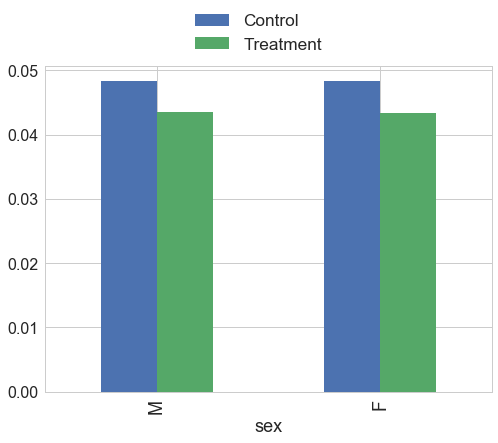

In [60]:
conversion_barplot(experiment_group, control_group, 'sex')

For ads_channel, we observed the same - that is the conversion rate of experiment group is lower than that of the control group.

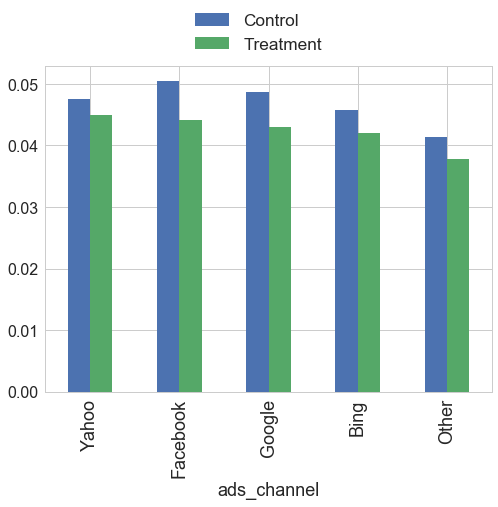

In [61]:
conversion_barplot(experiment_group, control_group, 'ads_channel')

However, when looking at different countries, we found some countries have a higher conversion rate in the experiment group than the control group. For example, Gabon, Marocco, and Andorra.

In [62]:
exp1 = experiment_group[experiment_group.country != 'Democratic Republic of the Congo']
trmt1 = control_group[control_group.country != 'Democratic Republic of the Congo']

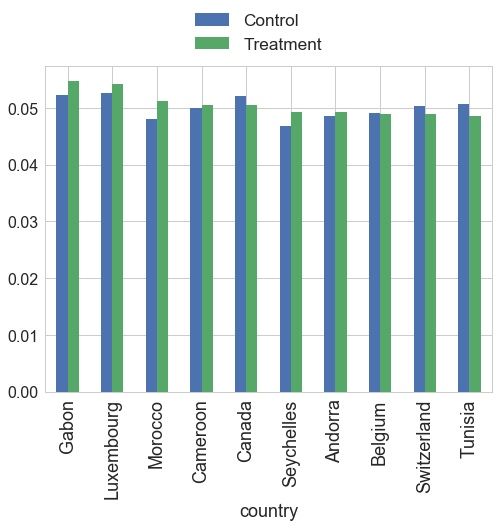

In [63]:
conversion_barplot(exp1, trmt1, 'country')

**Summary: ** We have identified that country may be a confounding factor that influences the coversion rate. In next section, let's dive deeper into this variable.

## 4. Conversion rate by country

In this section, let's look at conversion rate by country and check how many countries have a higher conversion rate in the experiment group than the control.

From the table below, we see that several countries have a higher conversion rate in the experiment group, for example Andorra, Cameroon, and Democratic Republic of the Congo.

In [64]:
conversion_by_country = test_user.groupby(['country', 'test']).conversion.mean().reset_index()
conversion_by_country

,country,test,conversion
0,Algeria,0,0.015071
1,Algeria,1,0.013725
2,Andorra,0,0.048493
3,Andorra,1,0.049229
4,Belgium,0,0.049154
5,Belgium,1,0.048988
6,Cameroon,0,0.049914
7,Cameroon,1,0.050604
8,Canada,0,0.052089
9,Canada,1,0.050571


In [65]:
test_user.groupby(['country', 'test']).conversion.count()

country                           test
Algeria                           0        9356
                                  1       37377
Andorra                           0        3650
                                  1        3697
Belgium                           0        8036
                                  1        7859
Cameroon                          0       16869
                                  1       16797
Canada                            0       27088
                                  1       26972
Democratic Republic of the Congo  0       64209
                                  1       64275
Gabon                             0        2660
                                  1        2649
Haiti                             0        5550
                                  1        5574
Luxembourg                        0        3419
                                  1        3304
Mauritius                         0         415
                                  1        3719
M

In [66]:
test_user.groupby(['country', 'test']).conversion.sum()

country                           test
Algeria                           0        141
                                  1        513
Andorra                           0        177
                                  1        182
Belgium                           0        395
                                  1        385
Cameroon                          0        842
                                  1        850
Canada                            0       1411
                                  1       1364
Democratic Republic of the Congo  0       3178
                                  1       3290
Gabon                             0        139
                                  1        145
Haiti                             0        274
                                  1        267
Luxembourg                        0        180
                                  1        179
Mauritius                         0          5
                                  1         48
Morocco              

Overall, we found that 25% of countries have higher conversion rates in the experiment group than the control group. But are these differences statistically significant?

In [67]:
tol = 0
for i in xrange(1, len(conversion_by_country.conversion), 2):
        if conversion_by_country.conversion[i] > conversion_by_country.conversion[i - 1]:
            tol += 1
print('Proportion of countries that have a higher conversion rate in the experiment group: {}'.\
      format(tol/len(conversion_by_country.conversion)))

Proportion of countries that have a higher conversion rate in the experiment group: 0.25


Next, let's use a Z-test to check whether the difference of conversion rates are statistically significant. We have the following hypotheses: 

H0: $Conversion\ rate_{experiment\ group} = Conversion\ rate_{control\ group}$

H1: $Conversion\ rate_{experiment\ group} < Conversion\ rate_{control\ group}$

When performing a two-sided Z-test for each country where, we found that all p-values are above the 0.05 significance level, therefore, we cannot reject the null hypothesis mentioned above.

**Conclusion: ** Localized translation didn't worsen the conversion rate.

In the next section, I will design an algorithm that raise a flag if the same situation seen by the team is happening again in the future.

In [38]:
country_df = test_user.groupby(['country'])
pvalue_df = country_df.apply(lambda x: two_sample_z_test(x, 'smaller')[1]).reset_index()
pvalue_df.columns = [u'country', 'pvalue']
pvalue_df

,country,pvalue
0,Algeria,0.160878
1,Andorra,0.558159
2,Belgium,0.480755
3,Cameroon,0.614029
4,Canada,0.211862
5,Democratic Republic of the Congo,0.917228
6,Gabon,0.656102
7,Haiti,0.359424
8,Luxembourg,0.609844
9,Mauritius,0.558611


## 5. Algorithm design 1 - stratification

In this section, I propose a system/function that will return false if the same problem is happenning again in the future and return true if the test results are reliable. The methodology is based on a technique called "stratification" where we put similar population into the same group and check the if difference in conversion rates is statistically different between the experiment and the control groups. This is to control for confounding effects from other variables.

Pseudo code:

Select a significance level alpha (e.g. 0.05) and run one-sided Z-test on the entire dataset.

If experiment group has a statiscally higher conversion rate than control group:
    
    return True

else:

    1. Put similar population into the same group based on their attributes, such as country, sex, and device. After this step we will have n groups
    2. Run two-sided Z-test and compute p-value for each of the n groups
    3. If there is more than (1- alpha) * 100% (e.g. 95%) of groups that have p values greater than alpha (0.05), return false, else return true.

In [39]:
def alert_system_stratification(df, cols, alpha):
    """
    This function will alert user if unreliable/negative test result
    apperas again
    
    @param - df: final data that's ready to be analyzed (after missing value imputation and so on)
    @param - cols: a list of columns to be grouped by
    @param - alpha: significance level of the alert system
    
    return - True or False
    """
    
    # HELPER FUNCTION
    def two_sample_z_test(df, alternative='two-sided'):
        """
        This function returns the P-value from a two-sample Z-test
        """
        test_df = df[df.test == 1]
        control_df = df[df.test == 0]
        
        test_convert = test_df.conversion.sum()
        control_convert = control_df.conversion.sum()
        
        test_n = len(test_df.conversion)
        control_n = len(control_df.conversion)
        z, p_value = sm.stats.proportions_ztest([test_convert, control_convert], [test_n, control_n],
                                               alternative=alternative)
        return(z, p_value)

    
    # MAIN PART OF FUNCTION
    # compute p-value for Z-test, in this step we use data for all countries  
    z_score, p_value_all_data = two_sample_z_test(df, alternative='smaller')
    
    # return True if we fail to reject the null hypothesis where test_conversion_rate >= control_conversion_rate
    if p_value_all_data > alpha:
        return True
    
    # else put population into groups based on user provided column names and perform Z-test for each group
    else:   
        group_df = test_user.groupby(cols)
        pvalue_df = group_df.apply(two_sample_z_test).reset_index()
        pvalue_df.columns = cols + ['pvalue']
        
        # if (1-alpha) * 100 percent of the groups have p values higher than alpha, return False
        ratio = sum(pval > alpha for pval in pvalue_df.pvalue if pval > alpha) / len(pvalue_df.pvalue)
        if ratio > 1 - alpha:
            return False   
    return True

Test the algorithm:

Since we are looking at localized translation, it's necessary to alway put **country** in the column list passed into the function. If we were to use different translations for different age groups, then it'd be necessary for put age_group as the first element of the column list.

After grouping the population by country, sex, and device, the function returns false because the difference of the conversion rate is not statistically significant within each group.

In [40]:
alert_system_stratification(test_user, ['country', 'sex', 'device'], 0.05)

False

In [41]:
alert_system_stratification(test_user, ['country', 'browser_language'], 0.01)

False

## 6. Algorithm design 2 - logistic regression

Besides stratification, we can also rely on regression. For example, we can put confounding variables in the regression and check if the coefficent of experiment group is significantly different from the control group.

My algorithm will:

First, only use variable "test" in a logistic regression. If the p-value is <= than some significance level alpha and coefficient > 0:
        
        return True
        
Else:
run the regression with "test" and one of the other variables. If the p-value of "test" from at least one of the regressions is >= alpha or if the coefficient of "test" changes by 10% as compared to the simple regression with only "test":
        
        return False
        
Else:
run the regression with "test" and all other variables and check if the p-value of "test" >= 0.05 or coefficent of "test" changes by 10%:
    
        return False
        
return True if none of the above conditions are met, meaning the team is not going to encounter the same problem in the future.

In [68]:
import statsmodels.formula.api as smf
def alert_system_regression(df, cols, test_var, alpha):
    """
    This function will alert user if unreliable/negative test result
    apperas again
    
    @param - df: final data that's ready to be analyzed (after missing value imputation and so on)
    @param - cols: a list of possible confounding variables
    @param - test_var: dummy variable that indicates whether 
             a user belongs to test(1) or control(0)
    @param - alpha: significance level of the alert system
    
    return - True or False
    """
    
    def logit_reg(data, dependent_var, independent_vars):
        expression = '{}~'.format(dependent_var)
        if len(independent_vars) < 1:
            return 'Error: list is empty.'
        
        if len(independent_vars) == 1:
            expression += 'C({})'.format(independent_vars[0])
        else:    
            for var in independent_vars:
                expression += 'C({})+'.format(var)
            expression = expression[:-1]
        print('regression with {}'.format(expression))
        logit = smf.logit(formula=expression, data=df).fit()
        print()
        return logit

    logit = logit_reg(df, 'conversion', [test_var])
    coef = logit.params['C({})[T.1]'.format(test_var)]
    pval = logit.pvalues['C({})[T.1]'.format(test_var)]
    
    if coef > 0 and p_value <= alpha:
        return True
    
    for col in cols:
        logit_with_confounding = logit_reg(df, 'conversion', [test_var, col])
        coef_conf = logit_with_confounding.params['C({})[T.1]'.format(test_var)]
        pval_conf = logit_with_confounding.pvalues['C({})[T.1]'.format(test_var)]
        if abs((coef_conf - coef) / coef) >= 0.1 or pval_conf > alpha:
            return False
        
    logit_full = logit_reg(df, 'conversion', cols + [test_var])
    coef_full = logit_full.params['C({})[T.1]'.format(test_var)]
    pval_full = logit_full.pvalues['C({})[T.1]'.format(test_var)]
    if abs((coef_full - coef) / coef) >= 0.1 or pval_full > alpha:
        return False
   
    return True

In [137]:
cols =  ['source', 'device', 'country', 'ads_channel', 'browser', 'sex']
alert_system_regression(test_user, cols=cols, test_var='test', alpha=0.05)

regression with conversion~C(test)
Optimization terminated successfully.
         Current function value: 0.185560
         Iterations 7

regression with conversion~C(test)+C(source)
Optimization terminated successfully.
         Current function value: 0.185560
         Iterations 7

regression with conversion~C(test)+C(device)
Optimization terminated successfully.
         Current function value: 0.185558
         Iterations 7

regression with conversion~C(test)+C(country)
Optimization terminated successfully.
         Current function value: 0.183338
         Iterations 8



False

**Summary: ** When running the regression with "test" and "country", the system identified that the coefficent of "test" has changed by 10%, also the p-value is greater than 0.05, therefore it returns false. Let's eyeball the result this time.

First, let's run a regression with only "test". We found that the p-value of "test" is < 0.05, the coefficient is -0.1117

In [69]:
logit = smf.logit(formula='conversion ~ C(test)', data=test_user).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.185560
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:               401539
Model:                          Logit   Df Residuals:                   401537
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:               0.0003687
Time:                        17:36:23   Log-Likelihood:                -74510.
converged:                       True   LL-Null:                       -74537.
                                        LLR p-value:                 1.224e-13
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.9802      0.011   -275.315      0.000      -3.001      -2.959
C(test)[T.1]    -0.1122      0.015     -7.419      0.000      -0.142      -0.083
================================================================================
"""

Next, let's run a regression with "test" and "country". We found that p-value is 0.837 which is > 0.05. Also coefficient of "test" is 0.0031, it has changed over 10% compared to -0.1117.

In [70]:
logit = smf.logit(formula='conversion ~ C(test) + C(country)', data=test_user).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.183338
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:               401085
Model:                          Logit   Df Residuals:                   401068
Method:                           MLE   Df Model:                           16
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                 0.01193
Time:                        17:36:31   Log-Likelihood:                -73534.
converged:                       True   LL-Null:                       -74422.
                                        LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -4.2575      0.041   -103.257      0.000      -4.338      -4.177
C(test)[T.1]                                       0.0031      0.015      0.206      0.837      -0.027       0.033
C(country)[T.Andorra]                              1.2873      0.067     19.190      0.000       1.156       1.419
C(country)[T.Belgium]                              1.2918      0.054     23.903      0.000       1.186       1.398
C(country)[T.Cameroon]                             1.3169      0.047     28.115      0.000       1.225       1.409
C(country)[T.Canada]                               1.3392      0.044     30.314      0.000       1.253       1.426
C(country)[T.Democratic Republic of the Congo]     1.3187      0.042     31.663      0.000       1.237       1.400
C(country)[T.Gabon]                                1.3827      0.073     19.008      0.000       1.240       1.525
C(country)[T.Haiti]                                1.2824      0.059     21.631      0.000       1.166       1.399
C(country)[T.Luxembourg]                           1.3809      0.067     20.550      0.000       1.249       1.513
C(country)[T.Mauritius]                           -0.0891      0.144     -0.620      0.535      -0.371       0.193
C(country)[T.Morocco]                              1.3052      0.051     25.383      0.000       1.204       1.406
C(country)[T.Republic of the Congo]                1.3275      0.064     20.705      0.000       1.202       1.453
C(country)[T.Senegal]                              1.2957      0.064     20.321      0.000       1.171       1.421
C(country)[T.Seychelles]                           1.2705      0.084     15.078      0.000       1.105       1.436
C(country)[T.Switzerland]                          1.3045      0.047     27.604      0.000       1.212       1.397
C(country)[T.Tunisia]                              1.3042      0.055     23.918      0.000       1.197       1.411
==================================================================================================================
"""